<a href="https://colab.research.google.com/github/AI-Junction/Diabetic-Retinopathy/blob/master/DiabeticRetinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check memory allocation to this sesssion

In [0]:
!pip install kaggle

In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

#filename = "/content/.kaggle/kaggle.json"
#filename = "/.kaggle/kaggle.json"
filename = "kaggle.json"
#os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [4]:
!ls -lha kaggle.json



---x-wx--T 1 root root 65 Jan 24 05:24 kaggle.json


In [5]:
os.path.isdir("/root/.kaggle")

False

In [6]:
dir_kaggle = "/root/.kaggle"
if not os.path.isdir(dir_kaggle):
  !mkdir -p ~/.kaggle  
!cp kaggle.json ~/.kaggle/
os.path.isdir(dir_kaggle)

True

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

Create training and test data in this allocated session of colaboratory

In [0]:
!mkdir '/content/Pneumonia-Detection'

In [9]:
!kaggle competitions files -c rsna-pneumonia-detection-challenge

name                                  size  creationDate         
-----------------------------------  -----  -------------------  
stage_2_detailed_class_info.csv        2MB  2018-10-25 21:57:44  
stage_2_sample_submission.csv        155KB  2018-10-25 21:57:44  
stage_2_train_labels.csv               1MB  2018-10-25 21:57:45  
stage_2_test_images.zip              377MB  2018-10-25 21:57:54  
stage_2_train_images.zip               3GB  2018-10-25 21:59:27  
GCP Credits Request Link - RSNA.txt    55B  2018-10-25 22:02:52  


In [10]:
if not os.path.isfile("/content/Pneumonia-Detection/stage_2_test_images.zip"):
  !kaggle competitions download -c rsna-pneumonia-detection-challenge -f stage_2_detailed_class_info.csv -p "/content/Pneumonia-Detection/"
  !kaggle competitions download -c rsna-pneumonia-detection-challenge -f stage_2_sample_submission.csv -p "/content/Pneumonia-Detection/"
  !kaggle competitions download -c rsna-pneumonia-detection-challenge -f stage_2_train_labels.csv -p "/content/Pneumonia-Detection/"
  !kaggle competitions download -c rsna-pneumonia-detection-challenge -f stage_2_test_images.zip -p "/content/Pneumonia-Detection/"
  !kaggle competitions download -c rsna-pneumonia-detection-challenge -f stage_2_train_images.zip -p "/content/Pneumonia-Detection/"
  !kaggle competitions download -c rsna-pneumonia-detection-challenge -f GCP Credits Request Link - RSNA.txt -p "/content/Pneumonia-Detection/"


  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 38.7MB/s]
  0% 0.00/155k [00:00<?, ?B/s]
100% 155k/155k [00:00<00:00, 23.7MB/s]
  0% 0.00/661k [00:00<?, ?B/s]
100% 661k/661k [00:00<00:00, 44.8MB/s]
 96% 361M/377M [00:03<00:00, 57.5MB/s]
100% 377M/377M [00:04<00:00, 96.4MB/s]
100% 3.28G/3.29G [00:38<00:00, 92.0MB/s]
100% 3.29G/3.29G [00:38<00:00, 92.6MB/s]
usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: unrecognized arguments: Request Link - RSNA.txt


In [11]:
!pip install pydicom

    100% |████████████████████████████████| 7.0MB 6.6MB/s 


In [0]:
if not os.path.isdir("/content/Pneumonia-Detection/train"):
  !mkdir "/content/Pneumonia-Detection/train"
  !unzip "/content/Pneumonia-Detection/stage_2_train_images.zip" -d "/content/Pneumonia-Detection/train"


In [0]:
if not os.path.isdir("/content/Pneumonia-Detection/test"):
  !mkdir "/content/Pneumonia-Detection/test"
  !unzip "/content/Pneumonia-Detection/stage_2_test_images.zip" -d "/content/Pneumonia-Detection/test"


In [14]:
if not os.path.isfile("/content/Pneumonia-Detection/stage_2_detailed_class_info.csv"):
  !unzip "/content/Pneumonia-Detection/stage_2_detailed_class_info.csv.zip" -d "/content/Pneumonia-Detection"


Archive:  /content/Pneumonia-Detection/stage_2_detailed_class_info.csv.zip
  inflating: /content/Pneumonia-Detection/stage_2_detailed_class_info.csv  


In [15]:
if not os.path.isfile("/content/Pneumonia-Detection/stage_2_train_labels.csv"):
  !unzip "/content/Pneumonia-Detection/stage_2_train_labels.csv.zip" -d "/content/Pneumonia-Detection"


Archive:  /content/Pneumonia-Detection/stage_2_train_labels.csv.zip
  inflating: /content/Pneumonia-Detection/stage_2_train_labels.csv  


In [0]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [0]:
df_train_labels = pd.read_csv('/content/Pneumonia-Detection/stage_2_train_labels.csv')

In [3]:
print(df_train_labels.shape)
print(df_train_labels.columns)
print(df_train_labels.head())

(30227, 6)
Index(['patientId', 'x', 'y', 'width', 'height', 'Target'], dtype='object')
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


In [0]:
df_train = df_train_labels.drop_duplicates('patientId')

In [0]:
x = df_train_labels[df_train_labels['patientId']=='cb4de6ed-efda-429e-941e-650cf9f6e33d']

In [6]:
print(x)

                                  patientId   x   y  width  height  Target
22488  cb4de6ed-efda-429e-941e-650cf9f6e33d NaN NaN    NaN     NaN       0


In [7]:
print(os.path.isfile('/content/Pneumonia-Detection/train/'+'cb4de6ed-efda-429e-941e-650cf9f6e33d.dcm'))

True


In [0]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('/content/Pneumonia-Detection/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        #print(filename)
        if os.path.isfile('/content/Pneumonia-Detection/train/'+filename+'.dcm'):
          #print("file is present ", filename)
          location = rows[1:5]
          pneumonia = rows[5]
          # if row contains pneumonia add label to dictionary
          # which contains a list of pneumonia locations per filename
          if pneumonia == '1':
              # convert string to float to int
              location = [int(float(i)) for i in location]
              # save pneumonia location in dictionary
              if filename in pneumonia_locations:
                  pneumonia_locations[filename].append(location)
              else:
                  pneumonia_locations[filename] = [location]
        else:
          print("file not present ", filename)

In [9]:
print(len(filenames))

NameError: ignored

In [10]:
print(len(pneumonia_locations))

6012


In [11]:
# load and shuffle filenames
folder = '/content/Pneumonia-Detection/train'
filenames = os.listdir(folder)
random.shuffle(filenames)
print(len(filenames))

26684


In [12]:
print(len(filenames))

26684


In [13]:
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 24124
n valid samples 2560


Total train images: 26684
Images with pneumonia: 6012


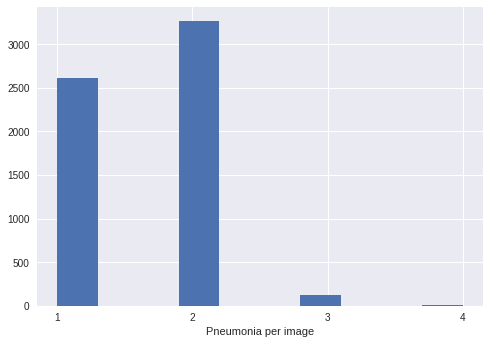

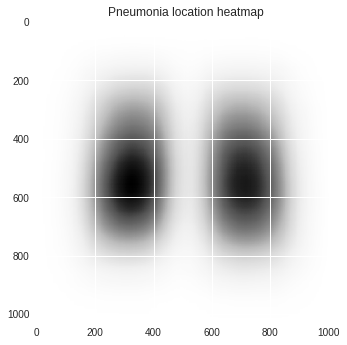

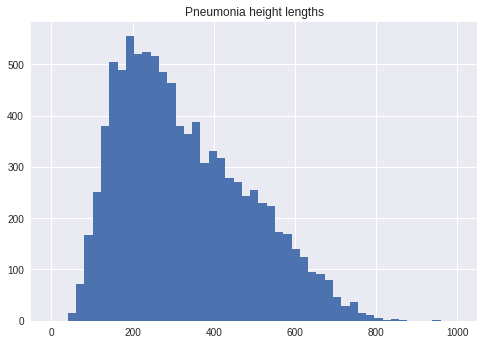

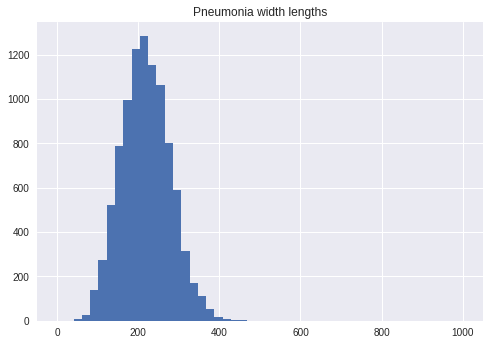

Minimum pneumonia height: 45
Minimum pneumonia width:  40


In [14]:
print('Total train images:',len(filenames))
print('Images with pneumonia:', len(pneumonia_locations))

ns = [len(value) for value in pneumonia_locations.values()]
plt.figure()
plt.hist(ns)
plt.xlabel('Pneumonia per image')
plt.xticks(range(1, np.max(ns)+1))
plt.show()

heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for values in pneumonia_locations.values():
    for value in values:
        x, y, w, h = value
        heatmap[y:y+h, x:x+w] += 1
        ws.append(w)
        hs.append(h)
plt.figure()
plt.title('Pneumonia location heatmap')
plt.imshow(heatmap)
plt.figure()
plt.title('Pneumonia height lengths')
plt.hist(hs, bins=np.linspace(0,1000,50))
plt.show()
plt.figure()
plt.title('Pneumonia width lengths')
plt.hist(ws, bins=np.linspace(0,1000,50))
plt.show()
print('Minimum pneumonia height:', np.min(hs))
print('Minimum pneumonia width: ', np.min(ws))

In [0]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [0]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [17]:
os.path.isfile('/content/train/cb4de6ed-efda-429e-941e-650cf9f6e33d.dcm')

False

In [19]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 2
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
folder = '/content/Pneumonia-Detection/train'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=2, workers=4, use_multiprocessing=True)

Epoch 1/2
753/753 [==============================] - 938s 1s/step - loss: 15.3894 - acc: 0.9620 - mean_iou: 0.6034 - val_loss: 15.5805 - val_acc: 0.9607 - val_mean_iou: 0.5831
Epoch 2/2
753/753 [==============================] - 938s 1s/step - loss: 14.0324 - acc: 0.9683 - mean_iou: 0.6783 - val_loss: 14.3154 - val_acc: 0.9638 - val_mean_iou: 0.6136


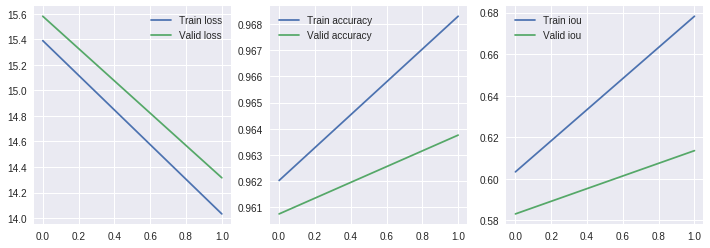

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

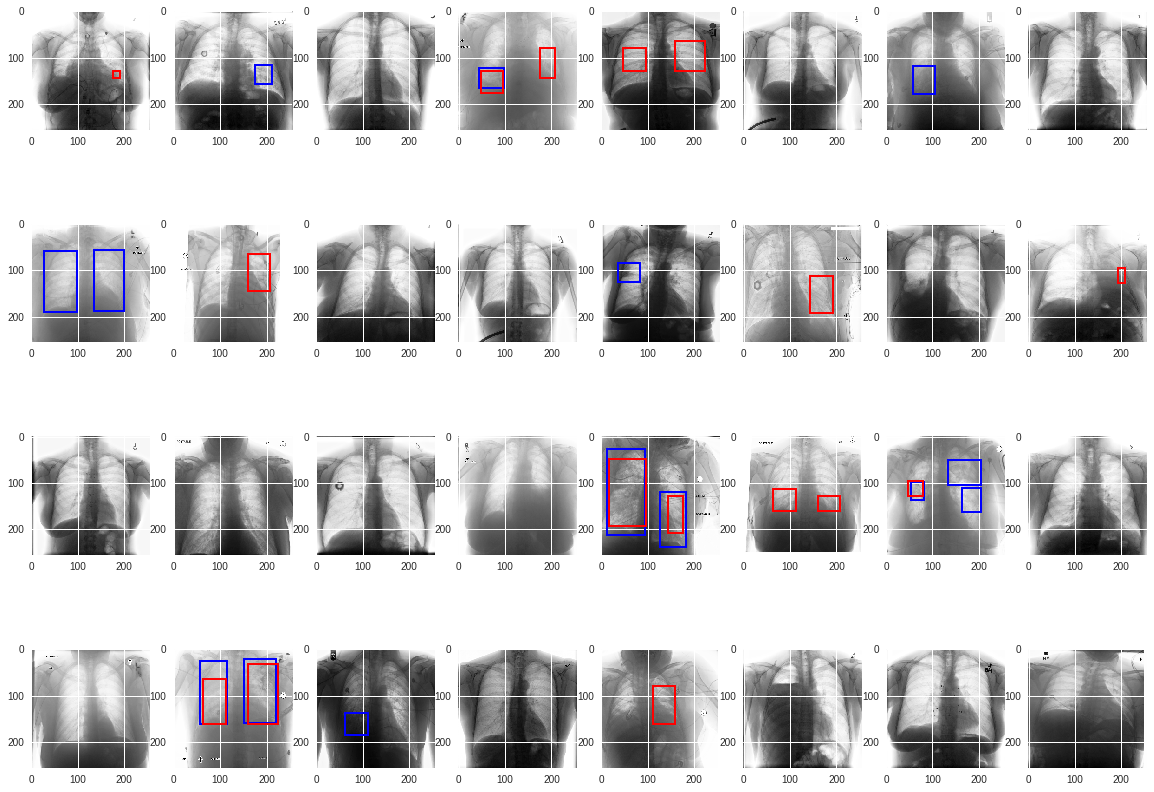

In [21]:
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

In [25]:
# load and shuffle filenames
folder = '/content/Pneumonia-Detection/test'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=25, image_size=256, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission.csv')

n test samples: 3000
